In [1]:
!pip install opencv-python

     |████████████████████████████████| 43.7 MB 10.3 MB/s eta 0:00:01


In [2]:
!pip3 install imutils
import imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=c64595b58131d35d8893da10bda3cd364f3a7a005e4f749371c239fc1558b03e
  Stored in directory: /home/jovyan/.cache/pip/wheels/c8/d6/0f/b0c3892b70c59f0d202f8619a449f7d14cb839a0af2f943869
Successfully built imutils


-------------LOADING IMAGES----------------
[INFO] compiling model...
----------------TRAINING HEAD NETWORK----------------
Epoch 1/32
17/17 [==============================] - 13s 787ms/step - loss: 0.2639 - accuracy: 0.8891 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 2/32
17/17 [==============================] - 13s 762ms/step - loss: 0.0251 - accuracy: 0.9981 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 3/32
17/17 [==============================] - 13s 744ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/32
17/17 [==============================] - 13s 755ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 5/32
17/17 [==============================] - 13s 741ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/32
17/17 [==============================] - 13s 752ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/32
17/17 [

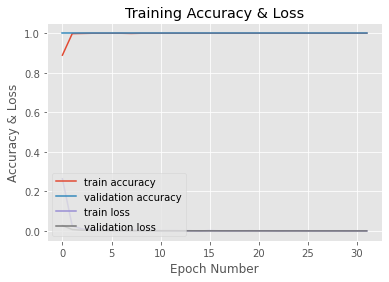

In [1]:
import numpy as np
import os
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from imutils import paths
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

dataset_path = '/home/jovyan/face-mask-detector2/dataset/'
plotname_path = '/home/jovyan/face-mask-detector2/plot.png'
modelname_path = "/home/jovyan/face-mask-detector2/face_detector/mask_detector.model"

# set hyperparameters, learning rate, epochs and batch size
initial_learning_rate = 2e-4 #
epochs = 32 #
batch_size = 64 #

# get images from the dataset directory
print("-------------LOADING IMAGES----------------")
imagePaths = list(paths.list_images(dataset_path))
labels = []
data = []


# loop through the paths of all the images
for imagePath in imagePaths:

	# load and preprocess the (224x244) input image and update the data list
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
    
	# extract the class label from the file and update the labes list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

labels = np.array(labels)#convert labels to np array
data = np.array(data, dtype="float32")#convert data to np array


# Do one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# split the data into train and test set 80% training and 20% testing
(Xtrain, Xtest, Ytrain, Ytest) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# build a the training image generator that augments the data
data_augmentor = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load imagenet weights from Mobile Net V2 without the head fully connected layer
imagenetw_model = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# build a head model to be placed on top of the base model
head_model = imagenetw_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)


# Put the fully connected head model in top of the base model to train the base model
model = Model(inputs=imagenetw_model.input, outputs=head_model)

# loop & freeze layers in base model to *not* update in the first training process
for layer in imagenetw_model.layers:
	layer.trainable = False

# compile the model
print("[INFO] compiling model...")
opts = Adam(lr=initial_learning_rate, decay=initial_learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opts,
	metrics=["accuracy"])

# train head network
print("----------------TRAINING HEAD NETWORK----------------")
trained_head_model = model.fit(
	data_augmentor.flow(Xtrain, Ytrain, batch_size=batch_size),
	steps_per_epoch=len(Xtrain) // batch_size,
	validation_data=(Xtest, Ytest),
	validation_steps=len(Xtest) // batch_size,
	epochs=epochs)

# predict the testing set
print("--------------EVALUATING HEAD NETWORK----------------")
predicted_Ids = model.predict(Xtest, batch_size=batch_size)

# Find index label with the largest predicted probability per test set image
predicted_Ids = np.argmax(predicted_Ids, axis=1)

# print classification report
print(classification_report(Ytest.argmax(axis=1), predicted_Ids,
	target_names=lb.classes_))#

# serialize the model to disk
print("--------------------SAVING MODEL---------------------")
model.save(modelname_path, save_format="h5")

# plot training accuracy & loss

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), trained_head_model.history["accuracy"], label="train accuracy")
plt.plot(np.arange(0, epochs), trained_head_model.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, epochs), trained_head_model.history["loss"], label="train loss")
plt.plot(np.arange(0, epochs), trained_head_model.history["val_loss"], label="validation loss")
plt.title("Training Accuracy & Loss")#
plt.xlabel("Epoch Number")#
plt.ylabel("Accuracy & Loss")#
plt.legend(loc="lower left")#
plt.savefig(plotname_path)#